## (1) Initial Setup ##

In [1]:
from datetime import datetime as dt
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV, LinearRegression
from statsmodels.formula.api import ols, glm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, average_precision_score, f1_score, 
                             ConfusionMatrixDisplay)
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [3]:
defaulter = pd.read_csv('data/credit card_defaults.csv')

In [4]:
pd.set_option('display.max_columns', None)
defaulter.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
defaulter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   BILL_AMT1                   30000 non-null  int64
 7   BILL_AMT2                   30000 non-null  int64
 8   BILL_AMT3                   30000 non-null  int64
 9   BILL_AMT4                   30000 non-null  int64
 10  BILL_AMT5                   30000 non-null  int64
 11  BILL_AMT6                   30000 non-null  int64
 12  PAY_AMT1                    30000 non-null  int64
 13  PAY_AMT2                    30000 non-null  int64
 14  PAY_AM

In [6]:
defaulter.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment this month    0
dtype: int64

In [7]:
defaulter.duplicated().sum()

0

## (2) Exploratory Data Analysis ##

<Axes: xlabel='SEX', ylabel='count'>

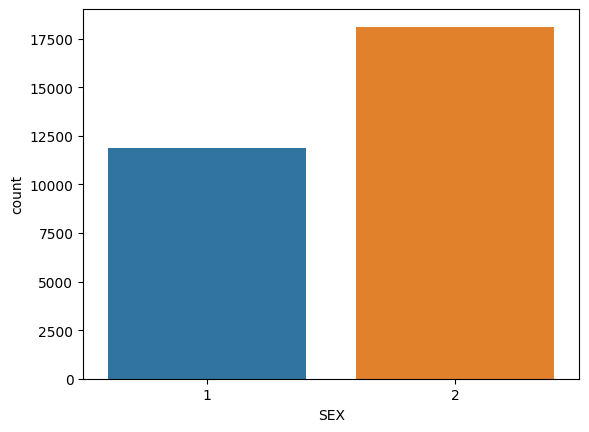

In [8]:
sns.countplot(x='SEX', data=defaulter)

<Axes: xlabel='EDUCATION', ylabel='count'>

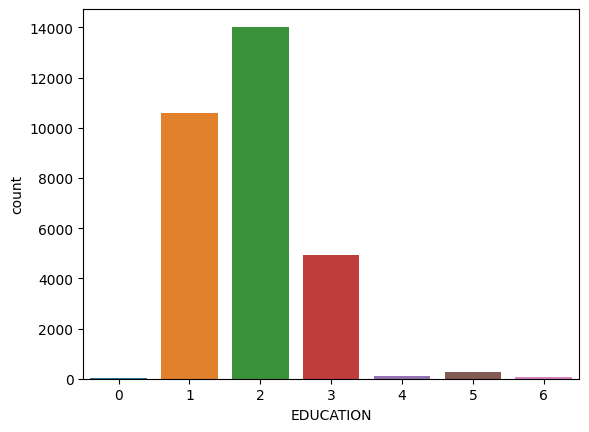

In [9]:
sns.countplot(x='EDUCATION', data=defaulter)

<Axes: xlabel='MARRIAGE', ylabel='count'>

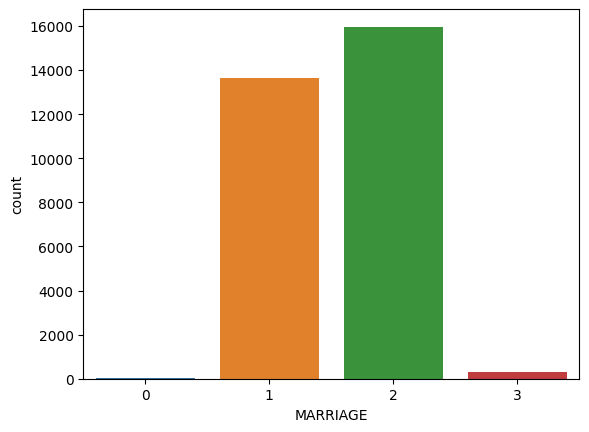

In [10]:
sns.countplot(x='MARRIAGE', data=defaulter)

<Axes: xlabel='default payment this month', ylabel='count'>

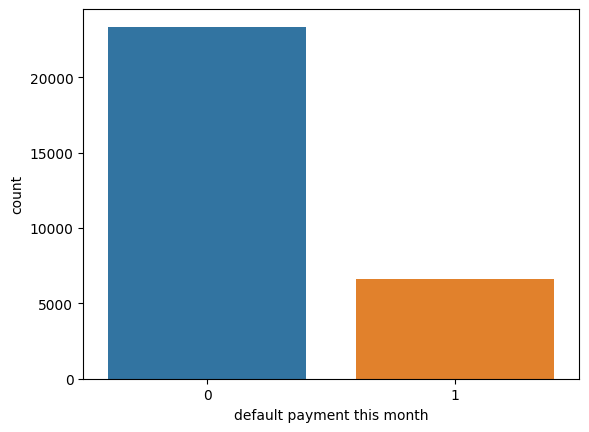

In [11]:
sns.countplot(x='default payment this month', data=defaulter)

<Axes: xlabel='AGE', ylabel='Count'>

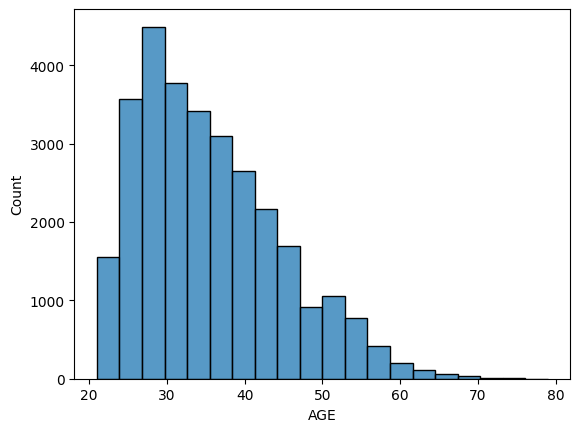

In [12]:
sns.histplot(data=defaulter,x='AGE',bins=20)

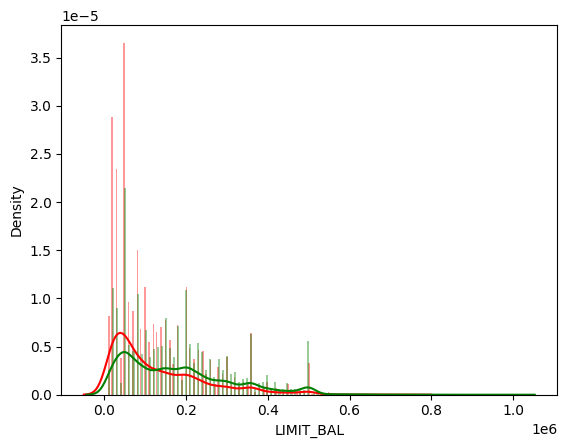

In [13]:
class_0 = defaulter.loc[defaulter['default payment this month'] == 0]["LIMIT_BAL"]
class_1 = defaulter.loc[defaulter['default payment this month'] == 1]["LIMIT_BAL"]
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

Most of defaults (class_1) are for credit limits 50,000, 20,000 and 30,000.

In [14]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=defaulter, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

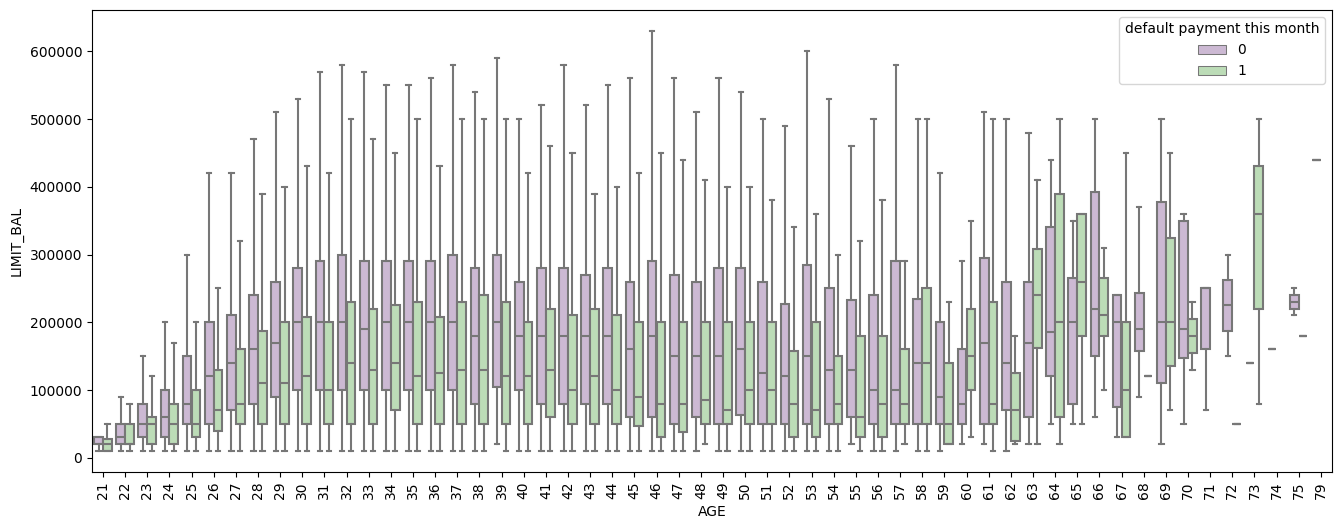

In [15]:
boxplot_variation('AGE','LIMIT_BAL', 'default payment this month',16)

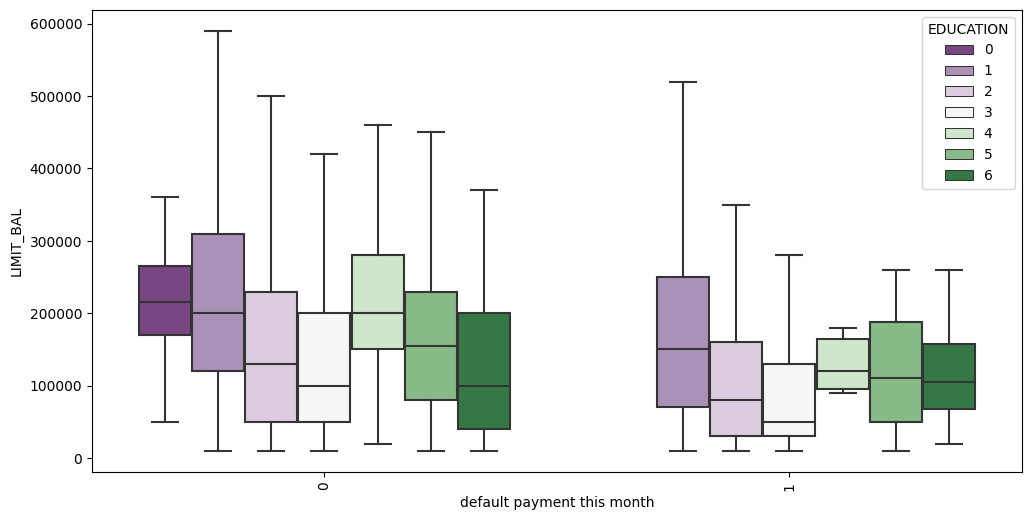

In [16]:
boxplot_variation('default payment this month','LIMIT_BAL', 'EDUCATION',12)

## (3) Feature Engineering ##

In [17]:
defaulter_1 = defaulter.copy()

Created a copy of the dataframe to prevent original dataframe from being overwritten

In [18]:
defaulter_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### 3.1 Latest Net Bill ###

In [19]:
defaulter_1['Net_Bill1'] = defaulter_1['BILL_AMT2'] - defaulter_1['PAY_AMT1']

### 3.2 Outstanding balance counts and Days Past Due 90 days ###

If there is an increase in card balances that are not repaid (defined as 90+ days past the due date of repayment), the regulator will ask the bank to hold more capital – resulting in a direct cost to the bank.

Created 3 new column OB (outstanding balance). Assuming that the BILL_AMT columns represent the total cumulative bill amount for each customer for the respective past month, then if bill amount is less than or equal to 0, means customer have paid their bills on time. If not, they would have an outstanding bill.

In [20]:
OB_1 = []

for i in defaulter_1['BILL_AMT1']:
    if i <= 0 : OB_1.append(0)
    
    
    else: OB_1.append(1)
        
        
defaulter_1['OB_1'] = OB_1

In [21]:
OB_2 = []

for j in defaulter_1['BILL_AMT2']:
    if j <= 0 : OB_2.append(0)
    
    
    else: OB_2.append(1)
        
        
defaulter_1['OB_2'] = OB_2 

In [22]:
OB_3 = []

for k in defaulter_1['BILL_AMT3']:
    if k <= 0 : OB_3.append(0)
    
    
    else: OB_3.append(1)
        
        
defaulter_1['OB_3'] = OB_3

If count value of columns OB_1, OB_2 and OB_3 are added together and gives a value of 3, means that customers have outstanding bill for the last 3 months. Indicate as 1 for those who have 90 days past due date for their bill payment.

In [23]:
defaulter_1['Count_OB'] = defaulter_1['OB_1'] + defaulter_1['OB_2'] + defaulter_1['OB_3']

In [24]:
DPD_90days = []

for i in defaulter_1['Count_OB']:
    if i == 3: DPD_90days.append(1)
    
    else: DPD_90days.append(0)
        
        
defaulter_1['DPD_90days'] = DPD_90days

### 3.3 Average bill & pay amount from past 6 months ###

In [25]:
defaulter_1['avg_bill'] = (defaulter_1['BILL_AMT1'] + defaulter_1['BILL_AMT2'] + defaulter_1['BILL_AMT3'] + defaulter_1['BILL_AMT4'] + defaulter_1['BILL_AMT5'] + defaulter_1['BILL_AMT6']) / 6

In [26]:
defaulter_1['avg_paid'] = (defaulter_1['PAY_AMT1'] + defaulter_1['PAY_AMT2'] + defaulter_1['PAY_AMT3'] + defaulter_1['PAY_AMT4'] + defaulter_1['PAY_AMT5'] + defaulter_1['PAY_AMT6']) / 6

### 3.4 Net worth column based on percentile of credit limit balance for each ID ###

We use credit limit balance to determine net worth, as most banks determine their credit limit from the income of the customer.

Considering top 25 percent of limit balance as high net worth, in between to be affluent and remaining 25 percent to be mass affluent. Indicate 3 levels of net worth in the column values. (1 = mass affluent, 2 = affluent and 3 = high net worth)

In [27]:
high_net_worth, affluent = defaulter_1.LIMIT_BAL.quantile(.75),defaulter_1.LIMIT_BAL.quantile(.25)

In [28]:
high_net_worth, affluent

(240000.0, 50000.0)

In [29]:
defaulter_1['Net_worth'] = pd.cut(x = defaulter_1.LIMIT_BAL,bins = [0,affluent,high_net_worth,5555555], labels = [1, 2, 3], include_lowest=True)

In [30]:
defaulter_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   ID                          30000 non-null  int64   
 1   LIMIT_BAL                   30000 non-null  int64   
 2   SEX                         30000 non-null  int64   
 3   EDUCATION                   30000 non-null  int64   
 4   MARRIAGE                    30000 non-null  int64   
 5   AGE                         30000 non-null  int64   
 6   BILL_AMT1                   30000 non-null  int64   
 7   BILL_AMT2                   30000 non-null  int64   
 8   BILL_AMT3                   30000 non-null  int64   
 9   BILL_AMT4                   30000 non-null  int64   
 10  BILL_AMT5                   30000 non-null  int64   
 11  BILL_AMT6                   30000 non-null  int64   
 12  PAY_AMT1                    30000 non-null  int64   
 13  PAY_AMT2        

In [31]:
defaulter_1['Net_worth'] = defaulter_1['Net_worth'].astype('int')

In [32]:
defaulter_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  int64  
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   BILL_AMT1                   30000 non-null  int64  
 7   BILL_AMT2                   30000 non-null  int64  
 8   BILL_AMT3                   30000 non-null  int64  
 9   BILL_AMT4                   30000 non-null  int64  
 10  BILL_AMT5                   30000 non-null  int64  
 11  BILL_AMT6                   30000 non-null  int64  
 12  PAY_AMT1                    30000 non-null  int64  
 13  PAY_AMT2                    300

In [33]:
defaulter_1['Net_worth'].value_counts()

2    15257
1     7676
3     7067
Name: Net_worth, dtype: int64

In [34]:
defaulter_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,3102,1,1,1,3,1,1284.000000,114.833333,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1725,1,1,1,3,1,2846.166667,833.333333,2
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,12509,1,1,1,3,1,16942.166667,1836.333333,2
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,46233,1,1,1,3,1,38555.666667,1398.000000,1
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,3670,1,1,1,3,1,18223.166667,9841.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,184315,1,1,1,3,1,120891.500000,7091.666667,2
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,-9,1,1,1,3,1,3530.333333,2415.000000,2
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,3356,1,1,1,3,1,11749.333333,5216.666667,1
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,-7521,0,1,1,2,0,44435.166667,24530.166667,2


## (4) Train Test Split ##

#### (4.1) Create the X and y datasets by dropping or keeping the target variable column

In [35]:
x = defaulter_1.drop(columns=['default payment this month'])
y = defaulter_1['default payment this month']

In [36]:
vif = x.drop(['ID','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','OB_1','OB_2','OB_3','Count_OB','avg_bill','Net_worth'],axis=1)

In [37]:
vif['intercept'] = 1

vif_data = pd.DataFrame()
vif_data["feature"] = vif.columns

vif_data["VIF"] = [variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])]
print(vif_data)

      feature        VIF
0   LIMIT_BAL   1.358759
1         SEX   1.019599
2   EDUCATION   1.122881
3    MARRIAGE   1.229121
4         AGE   1.274283
5   Net_Bill1   1.182605
6  DPD_90days   1.137816
7    avg_paid   1.167201
8   intercept  69.940510


In [38]:
x

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,3102,1,1,1,3,1,1284.000000,114.833333,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1725,1,1,1,3,1,2846.166667,833.333333,2
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,12509,1,1,1,3,1,16942.166667,1836.333333,2
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,46233,1,1,1,3,1,38555.666667,1398.000000,1
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,3670,1,1,1,3,1,18223.166667,9841.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,184315,1,1,1,3,1,120891.500000,7091.666667,2
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-9,1,1,1,3,1,3530.333333,2415.000000,2
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,3356,1,1,1,3,1,11749.333333,5216.666667,1
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-7521,0,1,1,2,0,44435.166667,24530.166667,2


In [39]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment this month, Length: 30000, dtype: int64

#### (4.2) Perform train test split
- Use ratio of train-test 80/20, and set random state as 1

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [41]:
x_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
28004,28005,20000,2,2,2,30,20128,17842,18979,7886,19786,20025,0,7027,1000,19000,6000,1000,17842,1,1,1,3,1,17441.000000,5671.166667,1
8560,8561,50000,2,2,1,32,316,282,316,316,316,316,282,350,316,316,316,316,0,1,1,1,3,1,310.333333,316.000000,1
15484,15485,180000,1,1,1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,2
12531,12532,20000,2,2,2,50,5100,2940,6050,3100,0,0,2940,6050,3100,0,0,1035,0,1,1,1,3,1,2865.000000,2187.500000,1
24473,24474,340000,1,1,2,49,1190,2988,390,1489,2140,1190,2988,390,1489,2140,1190,1190,0,1,1,1,3,1,1564.500000,1564.500000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17289,17290,170000,2,3,1,40,179399,41265,20619,19520,5200,0,0,2000,1136,1000,0,36679,41265,1,1,1,3,1,44333.833333,6802.500000,2
5192,5193,330000,2,1,1,41,4122,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,687.000000,0.000000,3
12172,12173,50000,1,2,2,22,49551,42517,35458,19778,19929,19790,1707,1321,687,705,811,874,40810,1,1,1,3,1,31170.500000,1017.500000,1
235,236,80000,1,1,2,35,7988,3977,6848,1719,1378,19942,3983,6853,1719,1378,19942,2418,-6,1,1,1,3,1,6975.333333,6048.833333,2


In [42]:
x_test

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
10747,10748,310000,1,3,1,32,172772,152397,110375,84373,57779,14163,8295,6000,4000,3000,1000,2000,144102,1,1,1,3,1,98643.166667,4049.166667,3
12573,12574,10000,2,3,1,49,32,-358,-748,1690,1138,930,0,0,2828,0,182,0,-358,1,0,0,1,0,447.333333,501.666667,1
29676,29677,50000,1,2,1,28,430,0,46257,45975,1300,43987,0,46257,2200,1300,43987,1386,0,1,0,1,2,0,22991.500000,15855.000000,1
8856,8857,80000,2,3,1,52,36649,39448,40101,40748,39816,40607,3700,1600,1600,0,1600,1600,35748,1,1,1,3,1,39561.500000,1683.333333,2
21098,21099,270000,1,1,2,34,20979,17228,20924,22448,15490,17343,0,4000,2000,0,2000,2000,17228,1,1,1,3,1,19068.666667,1666.666667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26329,26330,350000,2,2,2,34,-20,630,630,15722,2003,7264,650,0,15788,10,7299,13980,-20,0,1,1,2,0,4371.500000,6287.833333,3
29693,29694,380000,1,2,2,30,47765,47945,135167,95527,91541,92808,3000,90527,5000,3000,4000,3000,44945,1,1,1,3,1,85125.500000,18087.833333,3
16605,16606,50000,1,2,2,31,228,3183,5455,7629,6354,4655,2955,2500,2500,2526,2000,1500,228,1,1,1,3,1,4584.000000,2330.166667,1
19704,19705,20000,2,2,1,31,5500,8360,6000,0,0,0,3000,1000,0,0,0,0,5360,1,1,1,3,1,3310.000000,666.666667,1


#### (4.3) At this point, the `ID` column is still in our X datasets. It is not a column that we should use for prediction, so we should drop it. Before that, store the `ID` column of the X_test DataFrame as a variable called `X_test_id` (which we will use later)

In [43]:
x_test_id = x_test['ID']

In [44]:
x_test_id

10747    10748
12573    12574
29676    29677
8856      8857
21098    21099
         ...  
26329    26330
29693    29694
16605    16606
19704    19705
12785    12786
Name: ID, Length: 6000, dtype: int64

#### (4.4) Drop the `ID` column from both X_train and X_test DataFrames

In [45]:
x_train = x_train.drop(columns=['ID'])
x_test = x_test.drop(columns=['ID'])

## (5) SMOTE & Undersampling ##

In [46]:
pip install -U threadpoolctl

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.4.0
    Uninstalling threadpoolctl-3.4.0:
      Successfully uninstalled threadpoolctl-3.4.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tabpy 2.5.0 requires cloudpickle, which is not installed.
tabpy 2.5.0 requires mock, which is not installed.
tabpy 2.5.0 requires pytest, which is not installed.


In [47]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42)
x_smt, y_smt = smt.fit_resample(x_train, y_train)
Counter(y_smt)

Counter({1: 18701, 0: 18701})

In [48]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
x_under, y_under = undersampler.fit_resample(x_train, y_train)
Counter(y_under)

Counter({0: 5299, 1: 5299})

## (6) Model Training and Hyperparameter Tuning

### Model 1: Decision Tree ###

In [49]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(criterion="entropy",random_state=100,max_depth=10,min_samples_leaf=5)
dtree.fit(x_train,y_train)
y_pred_dtree=dtree.predict(x_test)

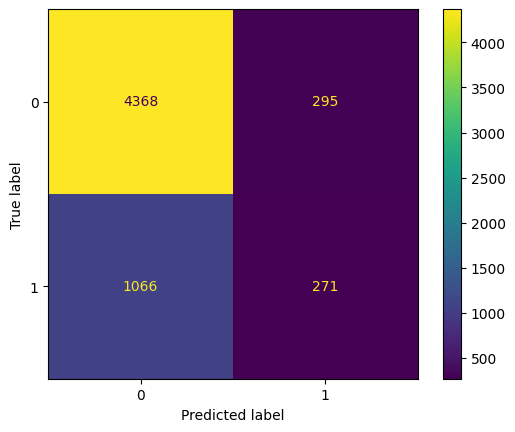

In [50]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dtree))

In [51]:
print("DT_under accuracy score",round(accuracy_score(y_test, y_pred_dtree),2))
print(classification_report(y_test, y_pred_dtree))

DT_under accuracy score 0.77
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      4663
           1       0.48      0.20      0.28      1337

    accuracy                           0.77      6000
   macro avg       0.64      0.57      0.58      6000
weighted avg       0.73      0.77      0.74      6000



In [52]:
import os
INSTALL_LOCATION = 'C:/Program Files/Graphviz/bin/'  # Edit this to match the install location on your computer
os.environ["PATH"] += os.pathsep + INSTALL_LOCATION

In [53]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.655026 to fit



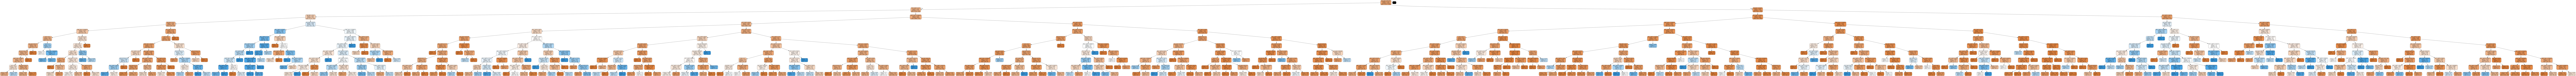

In [54]:
import graphviz
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                feature_names=x_train.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

<Axes: xlabel='importance', ylabel='Features'>

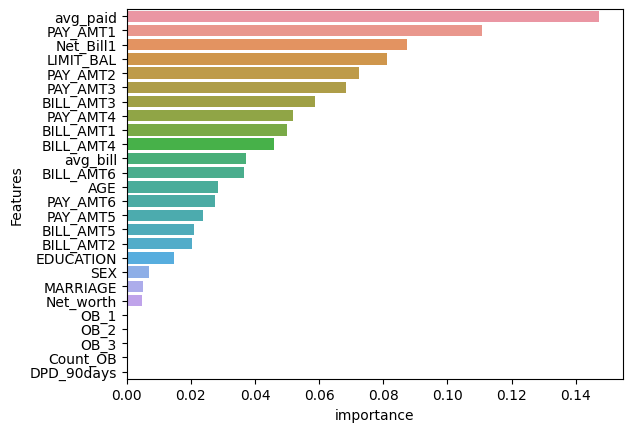

In [55]:
feat_imp = {'Columns':x_train.columns.values,'Coefficients':dtree.feature_importances_}
feat_imp = pd.DataFrame()
feat_imp['Features'] = x_train.columns.values
feat_imp['importance'] = dtree.feature_importances_
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(y="Features", x="importance", data=feat_imp)

### Model 2: Decision Tree Undersampling ###

In [56]:
import time
dtree_plus = DecisionTreeClassifier(random_state=42)
from sklearn.model_selection import train_test_split, GridSearchCV
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_dtree =GridSearchCV(dtree_plus, cv = 10,
                     param_grid=param_dist,
                     n_jobs = 3,scoring='accuracy')

cv_dtree.fit(x_under,y_under)
print('Best Parameters using grid search: \n',
     cv_dtree.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'criterion': 'entropy', 'max_depth': 4, 'max_features': None}
Time taken in grid search:  6.50


In [57]:
DT_under=DecisionTreeClassifier(criterion="entropy",random_state=100,max_depth=4,min_samples_leaf=5)
DT_under.fit(x_under,y_under)
y_pred_DT_under=DT_under.predict(x_test)

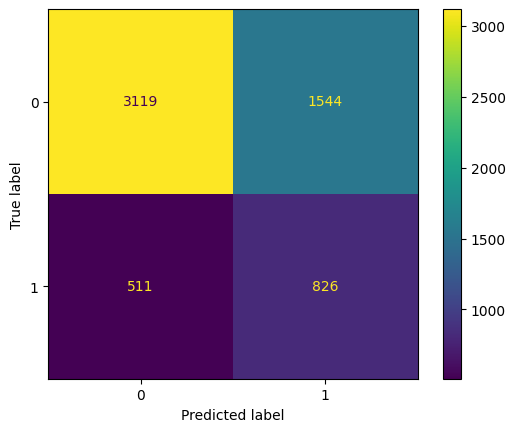

In [58]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_DT_under))

In [59]:
print("DT_under accuracy score",round(accuracy_score(y_test, y_pred_DT_under),2))
print(classification_report(y_test, y_pred_DT_under))

DT_under accuracy score 0.66
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      4663
           1       0.35      0.62      0.45      1337

    accuracy                           0.66      6000
   macro avg       0.60      0.64      0.60      6000
weighted avg       0.75      0.66      0.68      6000



<Axes: xlabel='importance', ylabel='Features'>

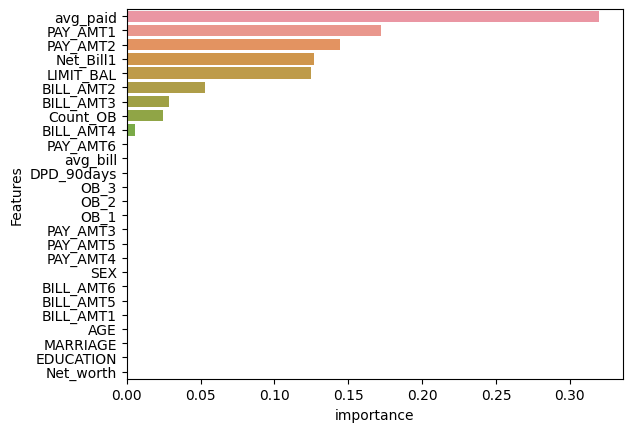

In [60]:
feat_imp = {'Columns':x_under.columns.values,'Coefficients':DT_under.feature_importances_}
feat_imp = pd.DataFrame()
feat_imp['Features'] = x_train.columns.values
feat_imp['importance'] = DT_under.feature_importances_
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(y="Features", x="importance", data=feat_imp)

### Model 3: Optimised Random Forest ###

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
from sklearn.model_selection import train_test_split, GridSearchCV
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf_tree =GridSearchCV(rf, cv = 10,
                     param_grid=param_dist,
                     n_jobs = 3,scoring='accuracy')

cv_rf_tree.fit(x_train,y_train)
print('Best Parameters using grid search: \n',
     cv_rf_tree.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'criterion': 'entropy', 'max_depth': 8, 'max_features': None}
Time taken in grid search:  3026.56


In [62]:
rf.set_params(criterion='entropy', max_features= None, max_depth=8)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       random_state=42)

In [63]:
rf.fit(x_train,y_train)
y_pred_rf=rf.predict(x_test)

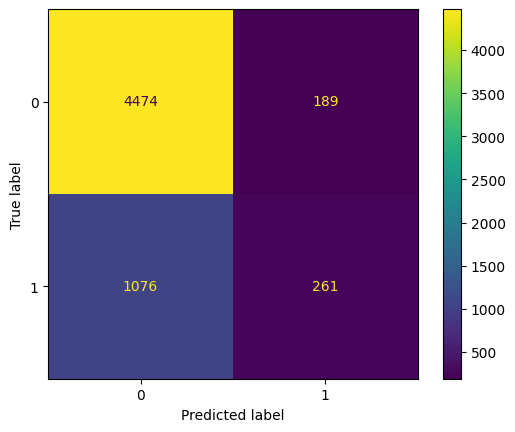

In [64]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf))

In [65]:
print("RF accuracy score",round(accuracy_score(y_test, y_pred_rf),2))
print(classification_report(y_test, y_pred_rf))

RF accuracy score 0.79
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4663
           1       0.58      0.20      0.29      1337

    accuracy                           0.79      6000
   macro avg       0.69      0.58      0.58      6000
weighted avg       0.76      0.79      0.75      6000



<Axes: xlabel='importance', ylabel='Features'>

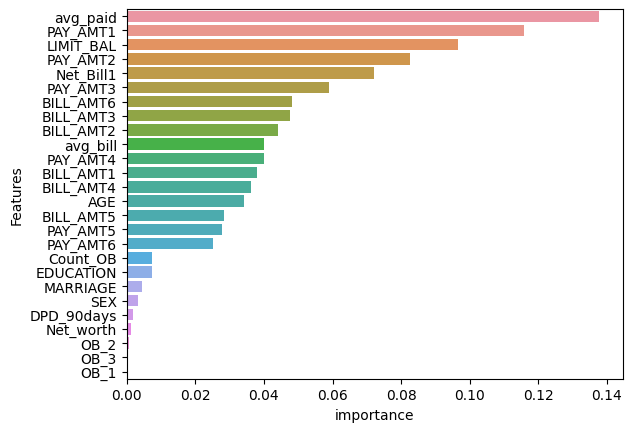

In [66]:
#feature Importance
feat_imp={'Columns':x_train.columns.values,'Coefficients':rf.feature_importances_}
feat_imp=pd.DataFrame()
feat_imp['Features']=x_train.columns.values
feat_imp['importance']=rf.feature_importances_
feat_imp=feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(y="Features", x="importance", data=feat_imp)

### Model 4: Optimised XGBoost (Champion)

In [67]:
xgb_params = {'max_depth': [3, 5, 6, 8, 9, 10, 11], # Maximum depth of a tree
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], # Step size shrinkage used in update to prevents overfitting
              'subsample': np.arange(0.4, 1.0, 0.1), #specifies the subsample ratio of the training instances that are randomly sampled without replacement to train each tree in the ensemble.
              'colsample_bytree': np.arange(0.3, 1.0, 0.1), # specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree in the ensemble
              'colsample_bylevel': np.arange(0.3, 1.0, 0.1),# specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree at each level. 
              'n_estimators': np.arange(100, 600, 100), #specifies the number of trees (estimators) to be used in the ensemble.
              'gamma': np.arange(0, 0.7, 0.1)} #controls the minimum reduction in the loss function required to make a split during tree building

# Loss function refers to the difference between the predicted y value with the actual y value. Eg. Mean Squared Error (MSE)

# Create RandomizedSearchCV instance

xgb_grid = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                      random_state=42),
                              param_distributions=xgb_params, 
                              cv=5, 
                              verbose=2,
                              n_iter=50,
                              scoring = recall_score
                             ) 

# cv specify the number of cross-validation folds to be used during the hyperparameter tuning process.
# verbose determines the verbosity level of the search process, meaning how much information about the progress and results of the search is printed to the console.
# verbose=0: No output will be printed during the search process.
# verbose=1: Some output will be printed, such as the progress of each iteration and the best parameters found so far.
# verbose=2: More detailed output will be printed, including the results of each iteration and the parameters tried.

# Run XGBoost grid search
xgb_grid.fit(x_train, y_train)

# Get best XGBoost model (based on best parameters) and predict on test set
xgb_best = xgb_grid.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bylevel=0.5, colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.6; total time=  25.1s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.6; total time=   4.2s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.6; total time=   4.5s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.6; total time=   4.5s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.8000000000000003, gamma=0.6000000000000001, learning_rate=0.5, max_depth=6, n_estimators=300, subsample=0.8999999999999999; total ti

[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.6000000000000001, learning_rate=0.1, max_depth=9, n_estimators=400, subsample=0.4; total time=   5.7s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.6000000000000001, learning_rate=0.1, max_depth=9, n_estimators=400, subsample=0.4; total time=   5.7s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.5, gamma=0.5, learning_rate=0.5, max_depth=6, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.5, gamma=0.5, learning_rate=0.5, max_depth=6, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.5, gamma=0.5, learning_rate=0.5, max_depth=6, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.5, gamma=0.5, learning_rate=0.5, max_depth=6, n_estimators=100, subsample=0.7; total

[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.5, gamma=0.30000000000000004, learning_rate=0.2, max_depth=8, n_estimators=200, subsample=0.7; total time=   3.9s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.5, gamma=0.30000000000000004, learning_rate=0.2, max_depth=8, n_estimators=200, subsample=0.7; total time=   4.4s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.5, gamma=0.30000000000000004, learning_rate=0.2, max_depth=8, n_estimators=200, subsample=0.7; total time=   4.7s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.2, learning_rate=0.3, max_depth=6, n_estimators=400, subsample=0.5; total time=  10.2s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.2, learning_rate=0.3, max_depth=6, n_estimators=400, subsample=0.5; total time=   9.0s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.2, learnin

[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.7; total time=   3.8s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7999999999999999; total time=   2.2s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7999999999999999; total time=   2.5s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7999999999999999; total time=   2.6s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7999999999999999; total time=   2.3s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=6, n_estima

[CV] END colsample_bylevel=0.4, colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   6.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   5.5s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.7999999999999999; total time=   2.8s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.7999999999999999; total time=   2.8s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.7999999999999999; total time=   4.2s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.7999999999999999; total

[CV] END colsample_bylevel=0.5, colsample_bytree=0.8000000000000003, gamma=0.1, learning_rate=0.5, max_depth=10, n_estimators=200, subsample=0.7; total time=   4.6s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.8000000000000003, gamma=0.1, learning_rate=0.5, max_depth=10, n_estimators=200, subsample=0.7; total time=   5.2s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.8000000000000003, gamma=0.1, learning_rate=0.5, max_depth=10, n_estimators=200, subsample=0.7; total time=   5.2s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.8000000000000003, gamma=0.1, learning_rate=0.5, max_depth=10, n_estimators=200, subsample=0.7; total time=   5.1s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.8000000000000003, gamma=0.1, learning_rate=0.5, max_depth=10, n_estimators=200, subsample=0.7; total time=   5.3s
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.4, gamma=0.6000000000000001, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.4; total time=   

In [68]:
xgb_grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [69]:
y_pred_xgb = xgb_best.predict(x_test)

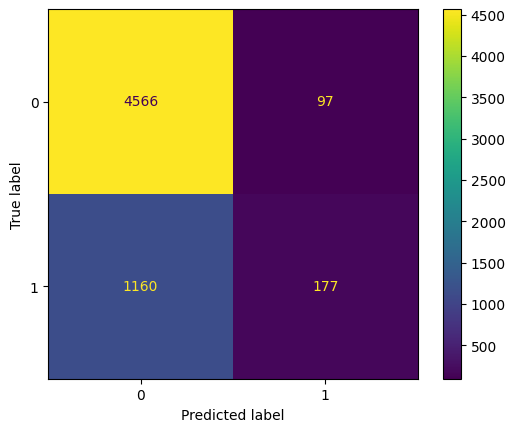

In [70]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb))

In [71]:
print("XGB accuracy score",round(accuracy_score(y_test, y_pred_xgb),2))
print(classification_report(y_test, y_pred_xgb))

XGB accuracy score 0.79
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4663
           1       0.65      0.13      0.22      1337

    accuracy                           0.79      6000
   macro avg       0.72      0.56      0.55      6000
weighted avg       0.76      0.79      0.73      6000



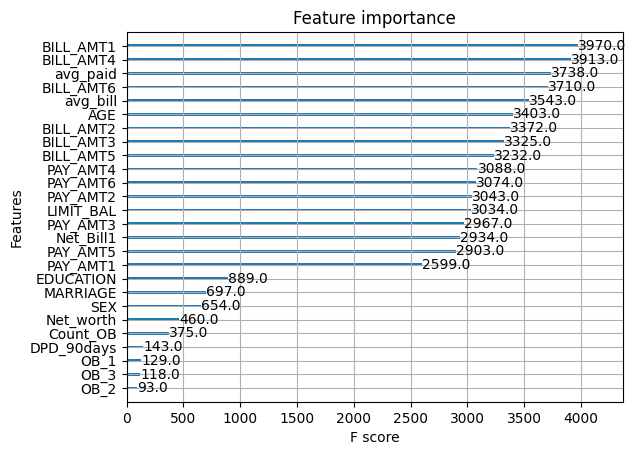

In [72]:
plot_importance(xgb_best)
plt.show()

In [73]:
x_train2 = x_train.drop(columns = ['Net_Bill1','EDUCATION', 'SEX', 'MARRIAGE','Net_worth','Count_OB','OB_1','DPD_90days','OB_2','OB_3'])

In [74]:
x_test2 = x_test.drop(columns = ['Net_Bill1','EDUCATION', 'SEX', 'MARRIAGE','Net_worth','Count_OB','OB_1','DPD_90days','OB_2','OB_3'])

In [75]:
xgb_params2 = {'max_depth': [3, 5, 6, 8, 9, 10, 11], # Maximum depth of a tree
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], # Step size shrinkage used in update to prevents overfitting
              'subsample': np.arange(0.4, 1.0, 0.1), #specifies the subsample ratio of the training instances that are randomly sampled without replacement to train each tree in the ensemble.
              'colsample_bytree': np.arange(0.3, 1.0, 0.1), # specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree in the ensemble
              'colsample_bylevel': np.arange(0.3, 1.0, 0.1),# specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree at each level. 
              'n_estimators': np.arange(100, 600, 100), #specifies the number of trees (estimators) to be used in the ensemble.
              'gamma': np.arange(0, 0.7, 0.1)} #controls the minimum reduction in the loss function required to make a split during tree building

# Loss function refers to the difference between the predicted y value with the actual y value. Eg. Mean Squared Error (MSE)

# Create RandomizedSearchCV instance

xgb_grid2 = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                      random_state=42),
                              param_distributions=xgb_params2, 
                              cv=5, 
                              verbose=2,
                              n_iter=50,
                              scoring = recall_score
                             ) 

# cv specify the number of cross-validation folds to be used during the hyperparameter tuning process.
# verbose determines the verbosity level of the search process, meaning how much information about the progress and results of the search is printed to the console.
# verbose=0: No output will be printed during the search process.
# verbose=1: Some output will be printed, such as the progress of each iteration and the best parameters found so far.
# verbose=2: More detailed output will be printed, including the results of each iteration and the parameters tried.

# Run XGBoost grid search
xgb_grid2.fit(x_train2, y_train)

# Get best XGBoost model (based on best parameters) and predict on test set
xgb_drop = xgb_grid2.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=400, subsample=0.7; total time=   8.0s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=400, subsample=0.7; total time=   7.2s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=400, subsample=0.7; total time=   7.9s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=400, subsample=0.7; total time=   9.4s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=400, subsample=0.7; total time=   7.6s
[CV] END colsample_bylevel=0.70000000000000

[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=11, n_estimators=500, subsample=0.5; total time=   8.8s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=11, n_estimators=500, subsample=0.5; total time=   8.8s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7; total time=   3.7s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7; total time=   4.5s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7; total time=   6.5s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7; total time=   5.1s
[CV] END col

[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.5; total time=   1.8s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.5; total time=   1.9s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.5; total time=   1.9s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.5; total time=   1.9s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.5; total time=   1.8s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.7000000000000002, gamma=0.2, learn

[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8999999999999999; total time=  10.0s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8999999999999999; total time=  10.5s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8999999999999999; total time=   9.9s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=10, n_estimators=500, subsample=0.8999999999999999; total time=   9.9s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.4, gamma=0.30000000000000004, learning_rate=0.5, max_depth=11, n_estimators=300, subsample=0.6; total time=   3.9s
[CV] END colsample_bylevel=0.3, colsample_bytree=0

[CV] END colsample_bylevel=0.3, colsample_bytree=0.6000000000000001, gamma=0.2, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.4; total time=   1.2s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.1, learning_rate=0.5, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   5.0s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.1, learning_rate=0.5, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   5.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.1, learning_rate=0.5, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   5.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.1, learning_rate=0.5, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   5.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.1, learning_rate=0.5, max_depth=5, n_esti

[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.4; total time=   4.3s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.4; total time=   4.2s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.4; total time=   4.2s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.4; total time=   4.4s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.4; total time=   4.2s
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.9000000000000001, gamma=0.1, learning_rate=0.2, max_depth=8, n_estimators=200, subsample=0.6; total time=   4.1s
[

In [76]:
xgb_grid2.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7000000000000002, colsample_bynode=None,
              colsample_bytree=0.7000000000000002, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [77]:
y_pred_xgb_drop = xgb_drop.predict(x_test2)

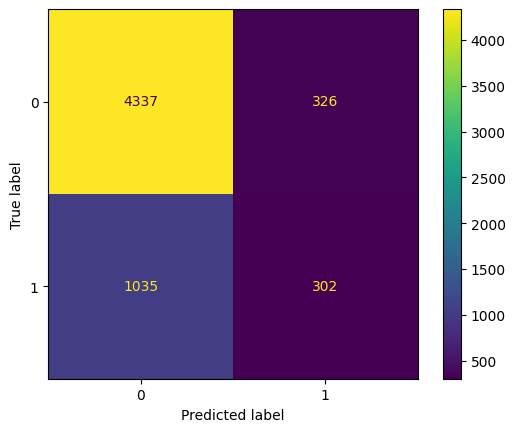

In [78]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_drop))

In [79]:
print("XGB_drop accuracy score",round(accuracy_score(y_test, y_pred_xgb_drop),2))
print(classification_report(y_test, y_pred_xgb_drop))

XGB_drop accuracy score 0.77
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      4663
           1       0.48      0.23      0.31      1337

    accuracy                           0.77      6000
   macro avg       0.64      0.58      0.59      6000
weighted avg       0.73      0.77      0.74      6000



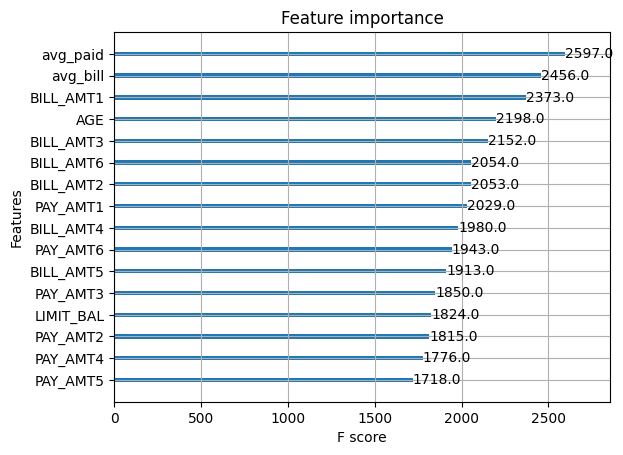

In [80]:
plot_importance(xgb_drop)
plt.show()

### (7) Identify Top 1000 Defaulters and its characteristics

Based on prediction probability, create a new column Propensity, which refers to the predicted propensity of the customer to default on the credit card bill payment

In [81]:
preds_proba = xgb_drop.predict_proba(x_test2)
y_preds_proba = preds_proba[:,1]

In [82]:
cust_default_propensity = pd.DataFrame({'ID': x_test_id,
                                      'PROPENSITY': y_preds_proba})

In [83]:
cust_default_propensity.sort_values(by=['PROPENSITY'], ascending=False).head(10)

,ID,PROPENSITY
23505,23506,0.992278
6647,6648,0.991604
24527,24528,0.990877
12767,12768,0.989856
17812,17813,0.989377
24075,24076,0.987213
20307,20308,0.986936
20721,20722,0.986832
16593,16594,0.985837
9428,9429,0.985521


Merge the data frame with the original dataframe, based on the customer ID

In [84]:
cust_default_propensity  = cust_default_propensity.merge(defaulter_1,
                                    on=['ID'],
                                    how='left')

In [85]:
cust_default_propensity

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
0,10748,0.002697,310000,1,3,1,32,172772,152397,110375,84373,57779,14163,8295,6000,4000,3000,1000,2000,0,144102,1,1,1,3,1,98643.166667,4049.166667,3
1,12574,0.517937,10000,2,3,1,49,32,-358,-748,1690,1138,930,0,0,2828,0,182,0,1,-358,1,0,0,1,0,447.333333,501.666667,1
2,29677,0.037470,50000,1,2,1,28,430,0,46257,45975,1300,43987,0,46257,2200,1300,43987,1386,0,0,1,0,1,2,0,22991.500000,15855.000000,1
3,8857,0.370523,80000,2,3,1,52,36649,39448,40101,40748,39816,40607,3700,1600,1600,0,1600,1600,1,35748,1,1,1,3,1,39561.500000,1683.333333,2
4,21099,0.115799,270000,1,1,2,34,20979,17228,20924,22448,15490,17343,0,4000,2000,0,2000,2000,0,17228,1,1,1,3,1,19068.666667,1666.666667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,26330,0.024985,350000,2,2,2,34,-20,630,630,15722,2003,7264,650,0,15788,10,7299,13980,0,-20,0,1,1,2,0,4371.500000,6287.833333,3
5996,29694,0.006856,380000,1,2,2,30,47765,47945,135167,95527,91541,92808,3000,90527,5000,3000,4000,3000,0,44945,1,1,1,3,1,85125.500000,18087.833333,3
5997,16606,0.054810,50000,1,2,2,31,228,3183,5455,7629,6354,4655,2955,2500,2500,2526,2000,1500,0,228,1,1,1,3,1,4584.000000,2330.166667,1
5998,19705,0.132327,20000,2,2,1,31,5500,8360,6000,0,0,0,3000,1000,0,0,0,0,0,5360,1,1,1,3,1,3310.000000,666.666667,1


As the test data set is only 20% of the full data, only 6000 rows are in the new data frame. From the cust_default_propensity data frame, added an expected loss column, where we define expected loss by multiplying the propensity to default with the latest total bill under BILL_AMT1

In [86]:
cust_default_propensity['EXPECTED_LOSS'] = cust_default_propensity['PROPENSITY'] * cust_default_propensity['BILL_AMT1']

Sort the based on expected loss column in descending order, and get the top 1000 expected loss values from the data

In [87]:
top_1000_loss = cust_default_propensity.sort_values(by=['EXPECTED_LOSS'], ascending=False).head(1000)

In [88]:
top_1000_loss.head()

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
2446,10781,0.938405,330000,1,1,2,44,604019,605943,439854,404157,370686,294348,19001,14000,12000,15000,7000,7000,0,586942,1,1,1,3,1,453167.833333,12333.500000,3,566814.147978
3111,27264,0.928268,470000,1,3,2,37,519901,499024,494290,470617,398523,389927,0,20600,19000,14000,13600,13600,1,499024,1,1,1,3,1,462047.000000,13466.666667,3,482607.531444
1307,11508,0.890705,500000,2,2,1,34,523618,483244,459273,386722,366421,241182,0,16004,15004,15004,9814,31004,0,483244,1,1,1,3,1,410076.666667,14471.666667,3,466389.133947
5578,6894,0.982232,370000,2,2,2,29,390509,382898,365461,304436,311426,275628,0,0,10019,11000,10000,10000,1,382898,1,1,1,3,1,338393.000000,6836.500000,3,383570.263237
1635,408,0.720716,500000,1,1,1,37,507062,491956,430637,376657,356636,303510,325,15296,12137,12312,14113,10526,0,491631,1,1,1,3,1,411076.333333,10784.833333,3,365447.756637


In [89]:
top_1000_loss.describe()

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14516.803000,0.426353,144786.000000,1.561000,1.952000,1.527000,36.020000,120547.407000,116853.517000,111309.43300,101917.032000,94092.938000,89546.965000,5434.64300,5524.609000,5226.563000,5281.761000,5219.949000,5510.309000,0.352000,111418.874000,1.0,0.994000,0.989000,2.983000,0.98800,105711.215333,5366.305667,1.916000,41590.636584
std,8737.120405,0.270302,115777.262788,0.496513,0.774788,0.513356,9.525772,105559.201694,102192.562912,99739.72968,93867.190268,88707.528076,85543.134936,11788.29286,15272.554507,18400.204773,14620.187554,15926.955543,18589.112565,0.477833,98877.992106,0.0,0.077266,0.104355,0.163517,0.10894,92029.901551,8014.277784,0.623966,51898.500449
min,23.000000,0.024810,16000.000000,1.000000,1.000000,0.000000,21.000000,11569.000000,-200.000000,-311.00000,0.000000,-604.000000,-1500.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3999.000000,1.0,0.000000,0.000000,1.000000,0.00000,4358.666667,0.000000,1.000000,10800.774921
25%,6808.250000,0.191133,60000.000000,1.000000,1.000000,1.000000,28.000000,47667.750000,46652.500000,42061.75000,37251.000000,30476.000000,29386.750000,1606.75000,1593.750000,1300.000000,1000.000000,1000.000000,845.750000,0.000000,44621.750000,1.0,1.000000,1.000000,3.000000,1.00000,40247.375000,1733.333333,2.000000,15314.700394
50%,14328.000000,0.380575,110000.000000,2.000000,2.000000,2.000000,34.000000,86432.000000,84915.500000,78309.00000,72542.500000,66124.000000,61142.500000,3415.50000,3400.000000,3000.000000,3000.000000,2800.000000,2300.000000,0.000000,80586.000000,1.0,1.000000,1.000000,3.000000,1.00000,75683.583333,3207.500000,2.000000,22951.706018
75%,21624.000000,0.643517,200000.000000,2.000000,2.000000,2.000000,42.000000,159651.250000,156091.750000,144465.00000,136048.250000,126753.250000,120718.250000,7000.00000,6521.500000,5800.000000,5342.750000,5104.500000,5000.000000,1.000000,148686.000000,1.0,1.000000,1.000000,3.000000,1.00000,139635.583333,5969.083333,2.000000,43800.490946
max,29979.000000,0.992278,730000.000000,2.000000,6.000000,3.000000,73.000000,746814.000000,624475.000000,689643.00000,628699.000000,524315.000000,513798.000000,276698.00000,340000.000000,508229.000000,220000.000000,279000.000000,279260.000000,1.000000,597607.000000,1.0,1.000000,1.000000,3.000000,1.00000,548854.333333,97697.000000,3.000000,566814.147978


In [90]:
top_1000_loss.SEX.value_counts()

2    561
1    439
Name: SEX, dtype: int64

In [91]:
top_1000_loss.EDUCATION.value_counts()

2    539
1    271
3    174
5      9
6      4
4      3
Name: EDUCATION, dtype: int64

In [92]:
top_1000_loss.MARRIAGE.value_counts()

2    516
1    477
3      6
0      1
Name: MARRIAGE, dtype: int64

In [93]:
top_1000_loss.Net_worth.value_counts()

2    604
1    240
3    156
Name: Net_worth, dtype: int64

### (8) Recommendation

From the top 1000 expected loss dataframe, we have taken a look at the demographic variables of the data set. In the predicted data set, there is a rather even distribution for the gender (SEX), marital status (MARRIAGE), and no useful insights can be extracted at the moment.

Below are some of the useful insights which may assist us with customer segmentation:

1. Age distribution: mean age for the group is at 36 years old
2. Net worth distribution: 60% of the group falls under category 2, in which the credit limit is between 50k to 240k
3. Education level distribution: About 54% of the group have an education at the University level.

Suggest to focus the user research to the above 3 criteria for further investigation

## (9) Kmean Clustering

In [94]:
data_a = cust_default_propensity

In [95]:
data_aa = data_a[data_a["default payment this month"]>0]

In [96]:
data_aa['EXPECTED_LOSS'] = data_aa['PROPENSITY'] * data_aa['BILL_AMT1']

In [97]:
data_aa = data_aa.sort_values(by=['EXPECTED_LOSS'], ascending=False)

In [98]:
data_aa_top_1000 = data_aa.sort_values(by=['EXPECTED_LOSS'], ascending=False).head(1000)

In [99]:
data_aa_top_1000

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
3111,27264,0.928268,470000,1,3,2,37,519901,499024,494290,470617,398523,389927,0,20600,19000,14000,13600,13600,1,499024,1,1,1,3,1,462047.000000,13466.666667,3,482607.531444
5578,6894,0.982232,370000,2,2,2,29,390509,382898,365461,304436,311426,275628,0,0,10019,11000,10000,10000,1,382898,1,1,1,3,1,338393.000000,6836.500000,3,383570.263237
4156,24938,0.858420,450000,1,1,1,37,387192,379442,387398,395655,403568,418182,0,14062,14700,14500,21077,12575,1,379442,1,1,1,3,1,395239.500000,12819.000000,3,332373.477601
4915,27441,0.548132,500000,1,1,1,35,510367,473584,167682,501496,508213,496801,24913,5872,508229,18089,14070,15009,1,448671,1,1,1,3,1,443023.833333,97697.000000,3,279748.607326
5968,20968,0.949093,150000,1,1,1,38,288585,282677,159283,148309,143972,139650,0,0,0,5000,5000,0,1,282677,1,1,1,3,1,193746.000000,1666.666667,2,273893.947242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461,7365,0.150374,150000,2,1,2,29,2356,16836,1094,6382,5288,5288,16836,2000,5288,0,0,0,1,0,1,1,1,3,1,6207.333333,4020.666667,2,354.281414
1837,25444,0.024925,300000,2,1,2,28,14033,6500,1477,0,0,1346,6520,1477,0,0,1346,0,1,-20,1,1,1,3,1,3892.666667,1557.166667,3,349.778498
1640,2463,0.015576,30000,1,1,2,28,22329,23665,47968,24784,25784,2901,2000,1400,2000,1000,1000,1000,1,21665,1,1,1,3,1,24571.833333,1400.000000,1,347.801024
1312,18454,0.185610,130000,2,1,2,26,1815,3520,727,-173,-173,-173,3532,857,1000,0,0,0,1,-12,1,1,1,3,1,923.833333,898.166667,2,336.882414


In [100]:
top_1000_defaulter = data_aa_top_1000.drop(columns = ["PROPENSITY","ID",'Net_Bill1','Net_worth','Count_OB','OB_1','DPD_90days','OB_2','OB_3',"default payment this month",
                                                     "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
                                                        "avg_bill","avg_paid"])

In [101]:
top_1000_defaulter

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,EXPECTED_LOSS
3111,470000,1,3,2,37,482607.531444
5578,370000,2,2,2,29,383570.263237
4156,450000,1,1,1,37,332373.477601
4915,500000,1,1,1,35,279748.607326
5968,150000,1,1,1,38,273893.947242
...,...,...,...,...,...,...
4461,150000,2,1,2,29,354.281414
1837,300000,2,1,2,28,349.778498
1640,30000,1,1,2,28,347.801024
1312,130000,2,1,2,26,336.882414


In [102]:
from sklearn import metrics
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as ss

In [103]:
kmeans = KMeans(n_clusters = 4, random_state = 0).fit(top_1000_defaulter)

In [104]:
kmeans.inertia_

2243082805979.2764

In [105]:
y_pred = kmeans.fit_predict(top_1000_defaulter)

ss(top_1000_defaulter,y_pred)

0.5234775708343973

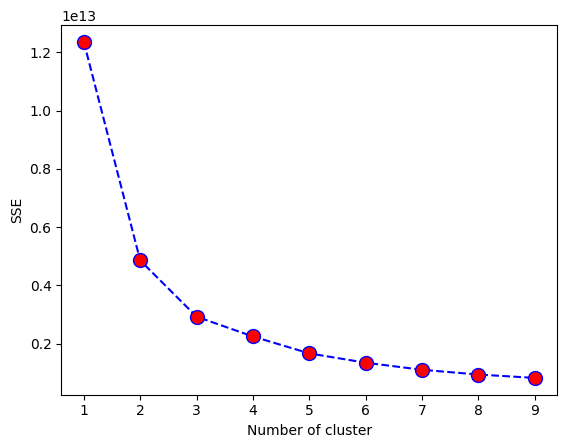

In [106]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(top_1000_defaulter)
    
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

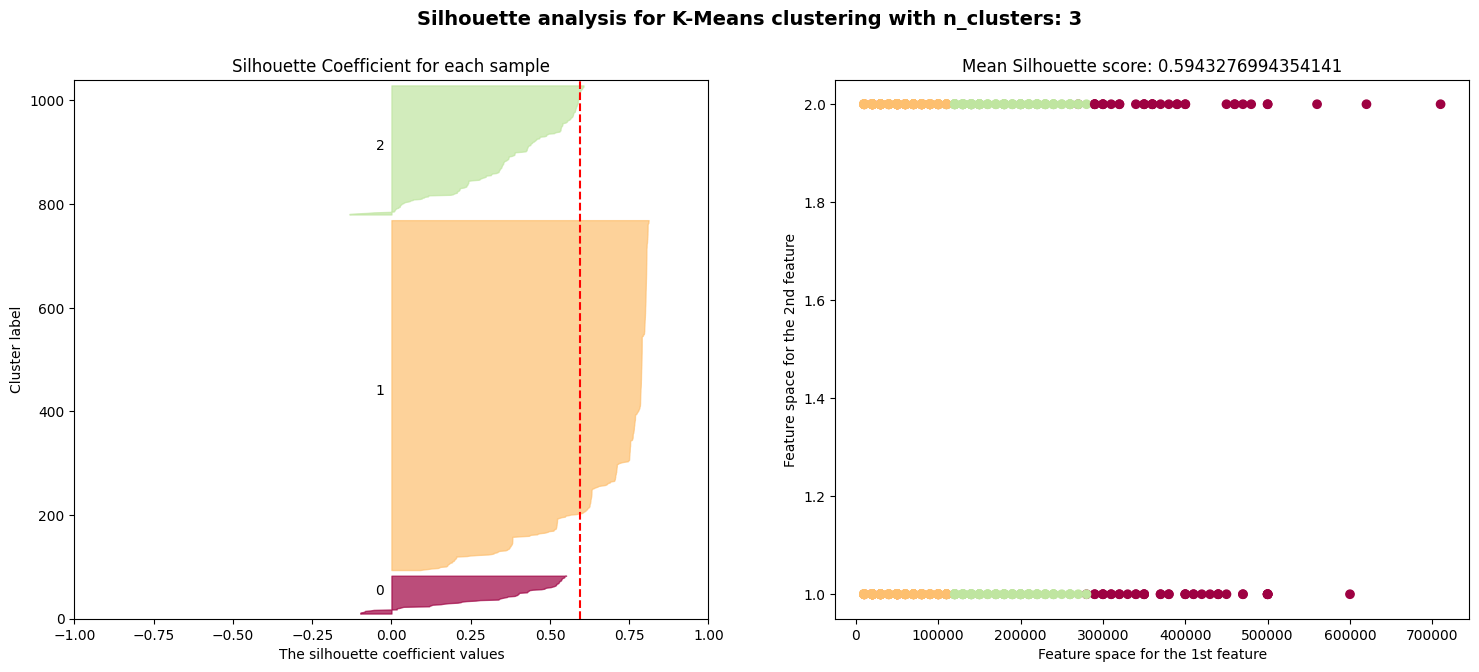

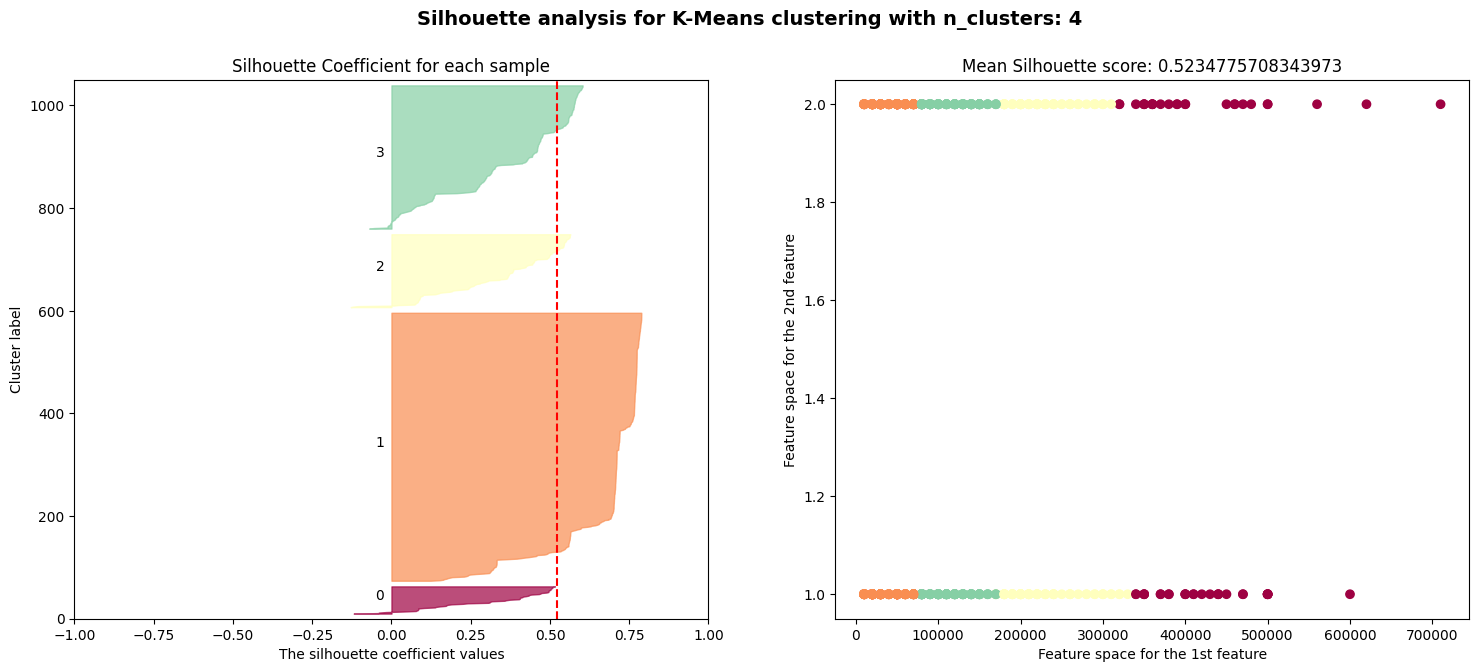

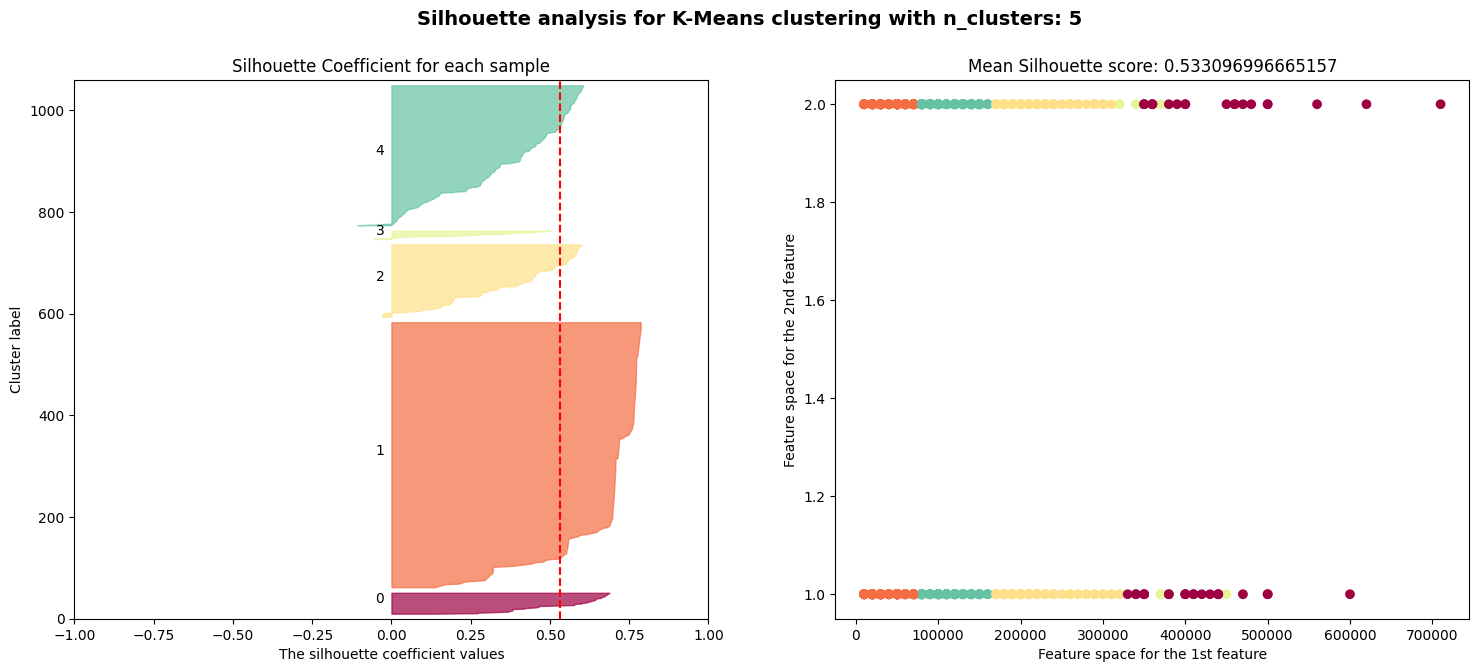

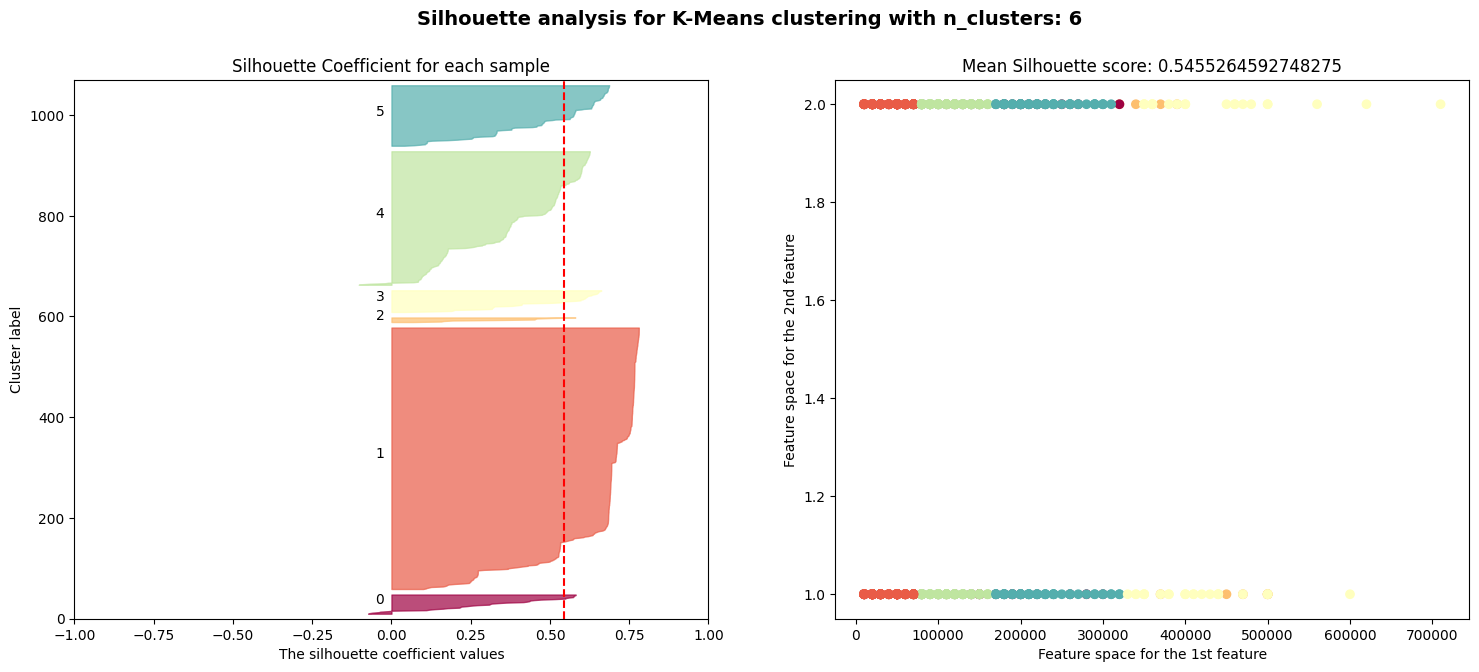

In [107]:
# X=scaled_data
X = np.array(top_1000_defaulter)

# List of number of clusters
range_n_clusters = [3, 4, 5, 6]

# For each number of clusters, perform Silhouette analysis and visualize the results.
for n_clusters in range_n_clusters:
    
    # Perform k-means.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = kmeans.fit_predict(X)
    
    
    
    # Compute the Silhouette Coefficient for each sample.
    s = metrics.silhouette_samples(X, y_pred)
    
    # Compute the mean Silhouette Coefficient of all data points.
    s_mean = metrics.silhouette_score(X, y_pred)
    
    # For plot configuration -----------------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Configure plot.
    plt.suptitle('Silhouette analysis for K-Means clustering with n_clusters: {}'.format(n_clusters),
                 fontsize=14, fontweight='bold')
    
    # Configure 1st subplot.
    ax1.set_title('Silhouette Coefficient for each sample')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Configure 2st subplot.
    ax2.set_title('Mean Silhouette score: {}'.format(s_mean))
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    # For 1st subplot ------------------------------------------------------------------------------------------
    
    # Plot Silhouette Coefficient for each sample
    y_lower = 10
    for i in range(n_clusters):
        ith_s = s[y_pred == i]
        ith_s.sort()
        size_cluster_i = ith_s.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    # Plot the mean Silhouette Coefficient using red vertical dash line.
    ax1.axvline(x=s_mean, color="red", linestyle="--")
    
    # For 2st subplot -------------------------------------------------------------------------------------------
    
    # Plot the predictions
    colors = cmap(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:,0], X[:,1], c=colors)

The value of the silhouette coefﬁcient is between -1 and 1. A score of 1 denotes the best.

n=3 has the best Silhouette score of 0.6 with ~0.2 SSE.

### Labeling the data using the selected number of clusters 

In [108]:
data_aa_top_1000_cluster=data_aa_top_1000

In [109]:
kmeans = KMeans(n_clusters=3,random_state=101)
kmeans.fit(top_1000_defaulter)
data_aa_top_1000_cluster['labels_n_3']= kmeans.labels_

In [110]:
data_aa_top_1000_cluster.groupby('labels_n_3').mean()

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,Net_Bill1,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
labels_n_3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15150.387574,0.353787,50236.686391,1.511834,2.063609,1.579882,34.359467,34018.331361,33800.325444,32569.474852,29545.952663,27506.272189,26657.316568,2162.766272,1943.43787,1719.093195,1868.853550,1661.686391,1783.378698,1.0,31637.559172,1.0,0.989645,0.971893,2.961538,0.968935,30682.945513,1856.535996,1.35503,10259.923570
1,13085.297297,0.213207,390675.675676,1.472973,1.608108,1.527027,36.891892,212322.297297,201247.418919,182992.148649,169197.013514,161894.229730,156466.000000,10116.337838,7701.22973,15300.094595,8542.324324,13596.054054,16916.945946,1.0,191131.081081,1.0,0.959459,0.959459,2.918919,0.945946,180686.518018,12028.831081,3.00000,59460.002381
2,13935.888000,0.299813,173400.000000,1.548000,1.788000,1.500000,36.060000,104807.908000,102174.008000,96928.444000,88994.300000,85149.916000,82625.520000,5163.268000,4387.04800,5257.888000,6626.628000,5143.876000,4973.764000,1.0,97010.740000,1.0,0.976000,0.968000,2.944000,0.964000,93446.682667,5258.745333,2.06800,29967.281148


In [111]:
kmeans = KMeans(n_clusters=3,random_state=101)
kmeans.fit(top_1000_defaulter)
data_aa_top_1000_cluster['labels_n_3']= kmeans.labels_
data_aa_top_1000_cluster.to_csv("cluster3.csv")